# **Simple Linear Regression**
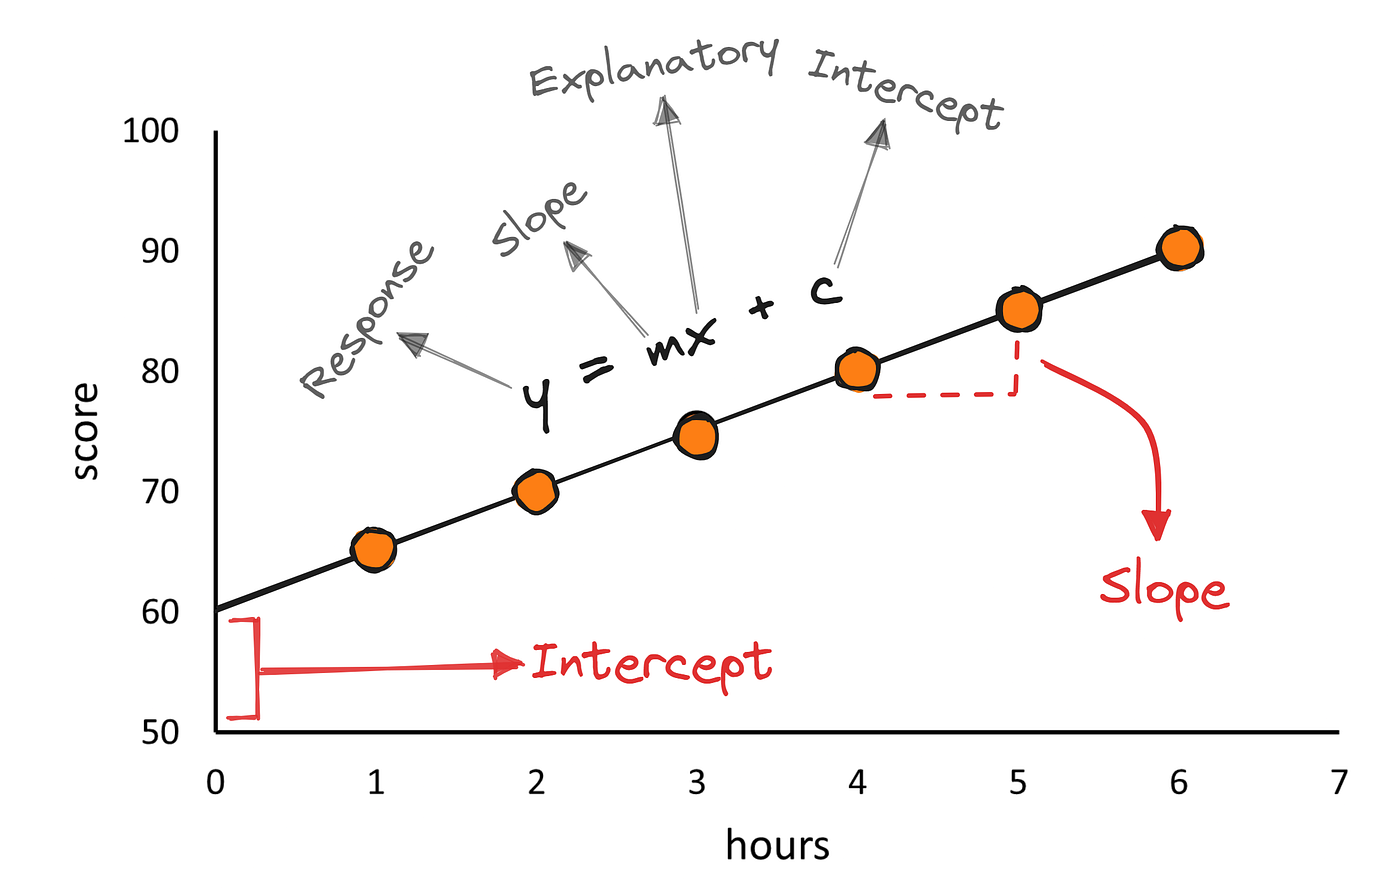

# **1. Importing libraries and handling the dataframe**

In [ ]:
# For handling matrices and dataframes
import numpy as np
import pandas as pd

# sklearn regression models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# filtering warnings
from warnings import filterwarnings
filterwarnings('ignore')


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sb
import plotnine as gg

In [ ]:
# Read CSV file
db = pd.read_csv('./archive/car_data.csv', sep=",")

In [ ]:
# Overview of the first 10 rows of the dataframe
db.head(10)

In [ ]:
# Statistical description of the dataframe
db.describe()

In [ ]:
# Using skimpy library to have a "pretty" dashboard-like overview
try:
    import skimpy
    print("skimpy is loaded")
except ImportError as e:
    print("skimpy is not available. Downloading..")
    !pip install skimpy

In [ ]:
from skimpy import skim
skim(db)

## **1.1 Feature subset selection**

In [ ]:
db['Car_Name'].nunique()

##### **The dataset has 98 different Car names, which is larger than the number of samples we have. From a data standpoint, it is better to remove the column Car_Name.**

In [ ]:
db.drop('Car_Name',axis=1,inplace=True)

## **1.2 Feature transformation**

In [ ]:
# Transforming the car's manufacturing year to car's age
db['Age'] = 2024 - db['Year']
db.drop('Year',axis=1,inplace=True)

In [ ]:
db.head()

# **2. Conducting Preprocessing + Exploratory Data Analysis**

## **2.1 Preprocessing**

In [ ]:
# Columns description
db.columns

In [ ]:
# Detecting Outliers for numerical features
numerical_columns = ['Selling_Price','Present_Price','Kms_Driven','Age']

i = 0
sb.set_palette("magma")

while i < 4:

    fig = plt.figure(figsize=[14,6])

    plt.subplot(1,2,1)
    sb.boxplot(x=numerical_columns[i],data=db)
    i += 1

    plt.subplot(1,2,2)
    sb.boxplot(x=numerical_columns[i],data=db)
    i += 1

    plt.show()

In [ ]:
# Detecting Outliers for categorical features
categorical_columns = ['Fuel_Type','Seller_Type','Transmission','Owner']

i = 0
sb.set_palette("magma")

while i < 4:

    fig = plt.figure(figsize=[14,6])

    plt.subplot(1,2,1)
    sb.boxplot(x=categorical_columns[i],data=db,y='Selling_Price')
    i += 1

    plt.subplot(1,2,2)
    sb.boxplot(x=categorical_columns[i],data=db,y='Selling_Price')
    i += 1

    plt.show()

##### The plots above show that several outliers are present in our dataset, especially in the Selling_Price Feature. Lets detect and filter (or not) these outliers using the IQR method.

In [ ]:
outliers = []

for i in numerical_columns:
    Q1 = db[i].quantile(0.25)
    Q3 = db[i].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outliers.extend(db[(db[i] < lower_bound) | (db[i] > upper_bound)].index.tolist())

for i in categorical_columns:
    for cat in db[i].unique():
        db1 = db[db[i] == cat]
        Q1 = db1['Selling_Price'].quantile(0.25)
        Q3 = db1['Selling_Price'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        outliers.extend(db1[(db1['Selling_Price'] < lower_bound) | (db1['Selling_Price'] > upper_bound)].index.tolist())

print('{} The indices of outliers in the dataset are:\n\n{}'.format(len(outliers), outliers))

## **2.2 Exploratory Data Analysis**
### **2.2.A Univariate Analysis**

In [ ]:
# Univariate Analysis of Categorical Variables

categorical_columns = ['Fuel_Type','Seller_Type','Transmission']

sb.set_palette("magma")

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for i, column in enumerate(categorical_columns):
    sb.countplot(x=column, data=db, ax=axes[i])

plt.suptitle('Frequency Analysis of Categorical Variables') 
plt.show()

In [ ]:
# Univariate Analysis of Numerical Variables

numerical_columns = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Age', 'Owner']

sb.set_palette("magma")
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for i, column in enumerate(numerical_columns):
    if i < 3:
        sb.histplot(x=column, data=db, ax=axes[0, i], kde=True, edgecolor='black', color='blue', alpha=1, line_kws={'lw': 3.0})
        axes[0, i].set_xticklabels(axes[0, i].get_xticklabels(), rotation=45, ha='right')
    else:
        sb.histplot(x=column, data=db, ax=axes[1, i-3], kde=True, edgecolor='black', color='blue', alpha=1, line_kws={'lw': 3.0})
        axes[1, i-3].set_xticklabels(axes[1, i-3].get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Histogram Analysis of Numerical Variables') 
plt.tight_layout()
plt.show()


In [ ]:
# We can conduct a statistical campain (mean, standard deviation, etc.)

# Compute statistics for numerical columns
statistics = db.describe()

# Print statistics for each numerical column
for column in numerical_columns:
    print(f"Statistics for {column}:")
    print(f"Mean: {statistics.loc['mean', column]}")
    print(f"Standard Deviation: {statistics.loc['std', column]}")
    print(f"Median: {statistics.loc['50%', column]}")
    print(f"Minimum value: {statistics.loc['min', column]}")
    print(f"Maximum value: {statistics.loc['max', column]}")


In [ ]:
# Multivariate Analysis of Numerical Variables

sb.pairplot(db[numerical_columns], diag_kind='kde')
plt.show()

##### Based on the pairplot above, we see that our data is right-skewed. The Present_Price is proportional to the Selling_Price. On the other hand, we can conclude that tha Selling_Price is inversly proportionnal to the number of Kms_Driven.

### **2.2.B Correlation Analysis**

##### Before conducting correlation analysis, we need to encode categorical variables (Fuel_Type, Seller_Type, Transmission).

In [ ]:
# Perform dummy encoding on categorical columns
db_encoded = pd.get_dummies(db, columns=['Fuel_Type', 'Seller_Type','Transmission'], drop_first=True)

db_encoded.head()

In [ ]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(pd.concat([db_encoded.drop("Selling_Price",axis=1), db_encoded["Selling_Price"]],axis=1).corr(), annot=True, cmap='coolwarm')

# Set the title and labels
plt.title('Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

# Show the heatmap
plt.show()

# **2. Building Linear Regression Model**

##### Before building our linear regression model, we need to drop the target variable, which is "Selling_Price"

## **2.1. Training/Testing datasets**

In [ ]:
db_X = db_encoded.drop("Selling_Price", axis=1)
db_Y = db_encoded["Selling_Price"]

In [ ]:
# Splitting and scaling the dataset into training/validation sets 
db_Xtrain, db_Xtest = train_test_split(db_X, test_size=0.3, random_state=42)
db_Ytrain, db_Ytest = train_test_split(db_Y, test_size=0.3, random_state=42)

scaler = StandardScaler()
db_Xtrain = pd.DataFrame(scaler.fit_transform(db_Xtrain))
db_Xtest = pd.DataFrame(scaler.transform(db_Xtest))

## **2.2. Building and training a linear regression model**

In [ ]:
# Linear regression model
reglm1 = LinearRegression()
model = reglm1.fit(db_Xtrain, db_Ytrain)

In [ ]:
# Get the intercept and coefficients
intercept = model.intercept_
coefficients = model.coef_

# Print the intercept and coefficients for each feature
for feature, coef in zip(db_X.columns, coefficients):
    print(f"{feature} Coeff: {coef}")

# Print the intercept
print(f"Intercept: {intercept}")

## **2.2. Evaluating the model**

In [ ]:
def compute_scores(db_Xvalidation,db_Yvalidation,regmodel):

    # Making predictions on the validation set
    db_Yval_pred = regmodel.predict(db_Xvalidation)

    # Computing the mean squared error (MSE)
    mse = mean_squared_error(db_Yvalidation, db_Yval_pred)

    # Computing the root mean squared error (RMSE)
    rmse = np.sqrt(mse)

    # Computing the mean absolute error (MAE)
    mae = mean_absolute_error(db_Yvalidation, db_Yval_pred)

    # Computing the R-squared score
    r2 = r2_score(db_Yvalidation, db_Yval_pred)

    # Printing the evaluation metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared Score: {r2}")

compute_scores(db_Xtest,db_Ytest,model)

# **3. Comparing with other models : Principal component regression (PCR), Partial Least Squares (PLS), LASSO, RIDGE, elasticnet, etc**

## **3.1. Principal component regression**

In [ ]:
pca = PCA(n_components=2)
model_pca = pca.fit(db_Xtrain, db_Ytrain)

pca = PCA(n_components = 7)
pca = pca.fit(db_Xtrain)
db_Xtrain_pca = pca.transform(db_Xtrain)
db_Xtest_pca = pca.transform(db_Xtest)
pcr_model = LinearRegression()
pcr_model.fit(db_Xtrain_pca, db_Ytrain)
pred_pcr = pcr_model.predict(db_Xtrain_pca)

compute_scores(db_Xtest_pca,db_Ytest,pcr_model)

## **3.2. Partial Least Squares**

In [ ]:
pls_model = PLSRegression(n_components = 7)
pls_model.fit(db_Xtrain,db_Ytrain)
pred_pls = pls_model.predict(db_Xtrain)

compute_scores(db_Xtest,db_Ytest,pls_model)

## **3.3. LASSO**

In [ ]:
lasso_model =  ElasticNet(l1_ratio = 1, alpha = 0.0001)

lasso_model.fit(db_Xtrain, db_Ytrain)
pred_lasso = lasso_model.predict(db_Xtrain)

compute_scores(db_Xtest,db_Ytest,lasso_model)

## **3.4. RIDGE**

In [ ]:
ridge_model = ElasticNetCV(l1_ratio = 1, alphas=np.arange(0.01, 1, 0.01), cv=100)
ridge_model.fit(db_Xtrain, db_Ytrain)
predictions_ridge = ridge_model.predict(db_Xtrain)

compute_scores(db_Xtest,db_Ytest,ridge_model)

## **3.5 Conclusion**

### Based on the metrics calculated, we can confidently say that PLS in the better algorithm to use for our dataset, even if the results are very close to each other. Nevertheless, because models like LASSO or RIDGE require finetuning to find the perfect values for l1_ratio, alpha, etc. It is easier to stick to simple models if precision is not important.

# **4. Lets Use PyCaret

##### *Based on PyCaret's official website, PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that exponentially speeds up the experiment cycle and makes you more productive.*

In [ ]:
from pycaret.regression import *
s = setup(data = db_encoded, target = 'Selling_Price', session_id = 123)
best = compare_models()
evaluate_model(best)

In [ ]:
# Next steps will involve conducting cross-validation in order to find the best hyperparameters for the models
